# Word Vectorizers

This notebook explains most of the data handling being made to proceed to the modeling part of the project. It consists of vectorizing my news data. All of the words were added to a corpus to be vectorized. Additionally, aggregated titles and articles were vectorized.

**Notebook Contents**
- [Imports](#Imports)
- [Read Data](#Read-Data)
- [Data Cleaning for NLP](#Data-Cleaning-for-NLP)
- [Tokenization](#Tokenization)
- [Vectorizer Analysis](#Vectorizer-Analysis)

## Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import gensim
from gensim.models.word2vec import Word2Vec

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.manifold import TSNE

from adjustText import adjust_text

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Read Data

In [3]:
news = pd.read_csv('../Datasets/aggregated_news.csv')
news.set_index('date', inplace=True)

## Data Cleaning for NLP

In [4]:
for i in range(len(news['article'])):
    news.loc[:,'article'][i] = news.loc[:,'article'][i].replace('U.S.', 'United States')

## Tokenization

This part is inspired by a source shared by my local instructor Cameron, it essentially sums every word in every new, tokenizes the words, cleans the objects that are not in the vocabulary (such as punctuations and letters), also removes anything that belongs to the set of stop words.

In [5]:
stop_words = set(stopwords.words('english'))

In [6]:
titles = news['title']
articles = news['article']

# Making a big list full of titles/articles
titles_list = [title for title in titles]
articles_list = [article for article in articles]

# Joining the titles/articles into one big string
all_titles_string = ' '.join(titles_list)
all_articles_string = ' '.join(articles_list)

# Tokenizing every word in titles/articles
title_tokens = word_tokenize(all_titles_string)
article_tokens = word_tokenize(all_articles_string)

# Cleaning the objects/strings that are not actually words
title_words =[word.lower() for word in title_tokens if word.isalpha()]
article_words = [word.lower() for word in article_tokens if word.isalpha()]

# Cleaning the stop words from the list of words
title_words = [word for word in title_words if not word in stop_words]
article_words = [word for word in article_words if not word in stop_words]

## Aggregated Tokenization

This second part is a code I have written myself to keep all the aggregated news together, so that I can treat every day of news individually and create an aggregated target vector for each day individually. Essentially everything done below is similar in structure, but keeps every row of news in a separate list.

In [7]:
# This is for aggregation of news per day

# Any line that ends with .copy() is just to replicate a 1153 len list within a list.
# This part is for tokenizing every title/article
agg_title_tokens = titles_list.copy()
for title in range(len(titles_list)):
    agg_title_tokens[title] = (word_tokenize(titles_list[title]))
agg_article_tokens = articles_list.copy()
for article in range(len(articles_list)):
    agg_article_tokens[article] = (word_tokenize(articles_list[article]))

# Removing the objects that are not words (are either punctuation or just one letter)
agg_title_words = agg_title_tokens.copy()
for title in range(len(agg_title_tokens)):
    agg_title_words[title] = [word.lower() for word in agg_title_tokens[title] if word.isalpha()]
agg_article_words = agg_article_tokens.copy()
for article in range(len(agg_article_tokens)):
    agg_article_words[article] = [word.lower() for word in agg_article_tokens[article] if word.isalpha()]

# Cleaning the stop words from the list of words for each title/article
agg_title_cleaned = agg_title_words.copy()
for title in range(len(agg_title_words)):
    agg_title_cleaned[title] = [word for word in agg_title_cleaned[title] if not word in stop_words]
agg_article_cleaned = agg_article_words.copy()
for article in range(len(agg_article_words)):
    agg_article_cleaned[article] = [word for word in agg_article_cleaned[article] if not word in stop_words]

## Word2Vec Model and Data Reshaping/Cleaning

In [8]:
model = gensim.models.KeyedVectors.load_word2vec_format('/Users/ataakca/Downloads/GoogleNews-vectors-negative300.bin.gz', binary = True)

In [9]:
wiki_model = gensim.models.KeyedVectors.load_word2vec_format('/Users/ataakca/Downloads/lexvec.enwiki+newscrawl.300d.W.pos.vectors.gz')

This code block essentially grabs all of the words that are in titles and articles, checks for every word that is in the vocabulary of our model. Filters out the ones that are not in the vocabulary, and creates pairs to plug the vector values and words into a dataframe.

In [10]:
title_vectors = [model[word] for word in title_words if word in model.vocab]
article_vectors = [model[word] for word in article_words if word in model.vocab]

title_filtered_words = [word for word in title_words if word in model.vocab]
article_filtered_words = [word for word in article_words if word in model.vocab]

title_vector_pairs = zip(title_filtered_words, title_vectors)
article_vector_pairs = zip(article_filtered_words, article_vectors)

title_dict = dict(title_vector_pairs)
article_dict = dict(article_vector_pairs)

title_vectors_df = pd.DataFrame.from_dict(title_dict, orient='index')
article_vectors_df = pd.DataFrame.from_dict(article_dict, orient='index')

In [11]:
print(f"words in titles that don't have vectors: {len(title_words) - len(title_vectors)}, percentage: {round((len(title_words) - len(title_vectors))/len(title_words), 5)*100}")
print(f"words in articles that don't have vectors: {len(article_words) - len(article_vectors)}, percentage: {round((len(article_words) - len(article_vectors))/len(article_words), 5)*100}")

words in titles that don't have vectors: 5264, percentage: 4.034
words in articles that don't have vectors: 10003, percentage: 3.701


In [12]:
# List of vectors of each words that are in our model
# for each row of news titles/articles
agg_title_vectors = agg_title_cleaned.copy()
for title in range(len(agg_title_cleaned)):
     agg_title_vectors[title] = [model[word] for word in agg_title_cleaned[title] if word in model.vocab] 
agg_article_vectors = agg_article_cleaned.copy()
for article in range(len(agg_article_cleaned)):
    agg_article_vectors[article] = [model[word] for word in agg_article_cleaned[article] if word in model.vocab]

# List of words of each words that are in our model
# for each row of news titles/articles
agg_title_filtered = agg_title_vectors.copy()
for title in range(len(agg_title_vectors)):
    agg_title_filtered[title] = [word for word in agg_title_cleaned[title] if word in model.vocab]  
agg_article_filtered = agg_article_vectors.copy()
for article in range(len(agg_article_vectors)):
    agg_article_filtered[article] = [word for word in agg_article_cleaned[article] if word in model.vocab]

# Mean of the vectors that belong to one row of aggregated news
agg_title_vectors_mean = agg_title_vectors.copy()
for title in range(len(agg_title_vectors)):
    agg_title_vectors_mean[title] = np.mean(agg_title_vectors[title], axis=0)
agg_article_vectors_mean = agg_article_vectors.copy()
for article in range(len(agg_article_vectors)):
    agg_article_vectors_mean[article] = np.mean(agg_article_vectors[article], axis=0)

In [13]:
df_title = pd.DataFrame(agg_title_vectors_mean)
df_article = pd.DataFrame(agg_article_vectors_mean)

In [14]:
df_title.index = news.index
df_article.index = news.index

## Mean Vectorizing and Visualizing the Vectors

t-SNE (t-distributed Stochastic Neighbor Embedding) is a 

In [15]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 1337, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_titles = tsne.fit_transform(title_vectors_df)
tsne_articles = tsne.fit_transform(article_vectors_df)
tsne_titles_vectorized = tsne.fit_transform(df_title)
tsne_articles_vectorized = tsne.fit_transform(df_article)

In [16]:
titles_vectorized = pd.DataFrame(tsne_titles_vectorized, columns=['x','y'])
titles_vectorized.index = news.index
titles_vectorized['compound'] = abs(titles_vectorized['x'] * titles_vectorized['y'])

articles_vectorized = pd.DataFrame(tsne_articles_vectorized, columns=['x','y'])
articles_vectorized.index = news.index
articles_vectorized['compound'] = abs(articles_vectorized['x'] * articles_vectorized['y'])

In [17]:
titles_vectorized.sort_values(by='compound').head(20)

x         y  compound
date                                    
2017-06-29  0.005304 -0.006310  0.000033
2019-09-08  0.151841 -0.003256  0.000494
2017-06-15  0.370903  0.005900  0.002188
2018-01-11  0.013845 -0.168440  0.002332
2018-06-27  0.002628 -2.185654  0.005745
2018-06-06  1.449200  0.004895  0.007094
2019-06-10  0.008250 -0.862346  0.007115
2019-11-08 -0.312601  0.023275  0.007276
2017-10-23  0.627221  0.012049  0.007558
2018-10-19  0.054636 -0.156312  0.008540
2018-03-13  0.262214 -0.039819  0.010441
2017-01-03 -0.328953  0.035866  0.011798
2017-02-26  1.937094  0.006117  0.011849
2019-12-11  1.063486 -0.012113  0.012882
2019-05-27 -0.082023  0.161967  0.013285
2019-03-15  0.007550 -1.771372  0.013374
2018-02-02 -2.225912 -0.006214  0.013832
2017-08-04  0.003700 -4.155322  0.015376
2019-08-28 -0.162525  0.096330  0.015656
2019-09-29  1.654377  0.010219  0.016906

In [18]:
zero_q_mask = titles_vectorized.sort_values(by='compound').head(20)
first_q_mask = titles_vectorized[(titles_vectorized['x'] > 0) & (titles_vectorized['y'] > 0)].sort_values(by='compound', ascending=False).head(20)
second_q_mask = titles_vectorized[(titles_vectorized['x'] < 0) & (titles_vectorized['y'] > 0)].sort_values(by='compound', ascending=False).head(20)
third_q_mask = titles_vectorized[(titles_vectorized['x'] > 0) & (titles_vectorized['y'] < 0)].sort_values(by='compound', ascending=False).head(20)
fourth_q_mask = titles_vectorized[(titles_vectorized['x'] < 0) & (titles_vectorized['y'] < 0)].sort_values(by='compound', ascending=False).head(20)

zero_q_mask_a = articles_vectorized.sort_values(by='compound').head(20)
first_q_mask_a = articles_vectorized[(articles_vectorized['x'] > 0) & (articles_vectorized['y'] > 0)].sort_values(by='compound', ascending=False).head(20)
second_q_mask_a = articles_vectorized[(articles_vectorized['x'] < 0) & (articles_vectorized['y'] > 0)].sort_values(by='compound', ascending=False).head(20)
third_q_mask_a = articles_vectorized[(articles_vectorized['x'] > 0) & (articles_vectorized['y'] < 0)].sort_values(by='compound', ascending=False).head(20)
fourth_q_mask_a = articles_vectorized[(articles_vectorized['x'] < 0) & (articles_vectorized['y'] < 0)].sort_values(by='compound', ascending=False).head(20)

In [19]:
tsne_titles

array([[-9.607696 ,  3.1932557],
       [19.44716  ,  6.520419 ],
       [39.228004 , 10.017167 ],
       ...,
       [26.767588 , -8.745263 ],
       [20.572962 , 18.10355  ],
       [ 6.6359777, -4.4129786]], dtype=float32)

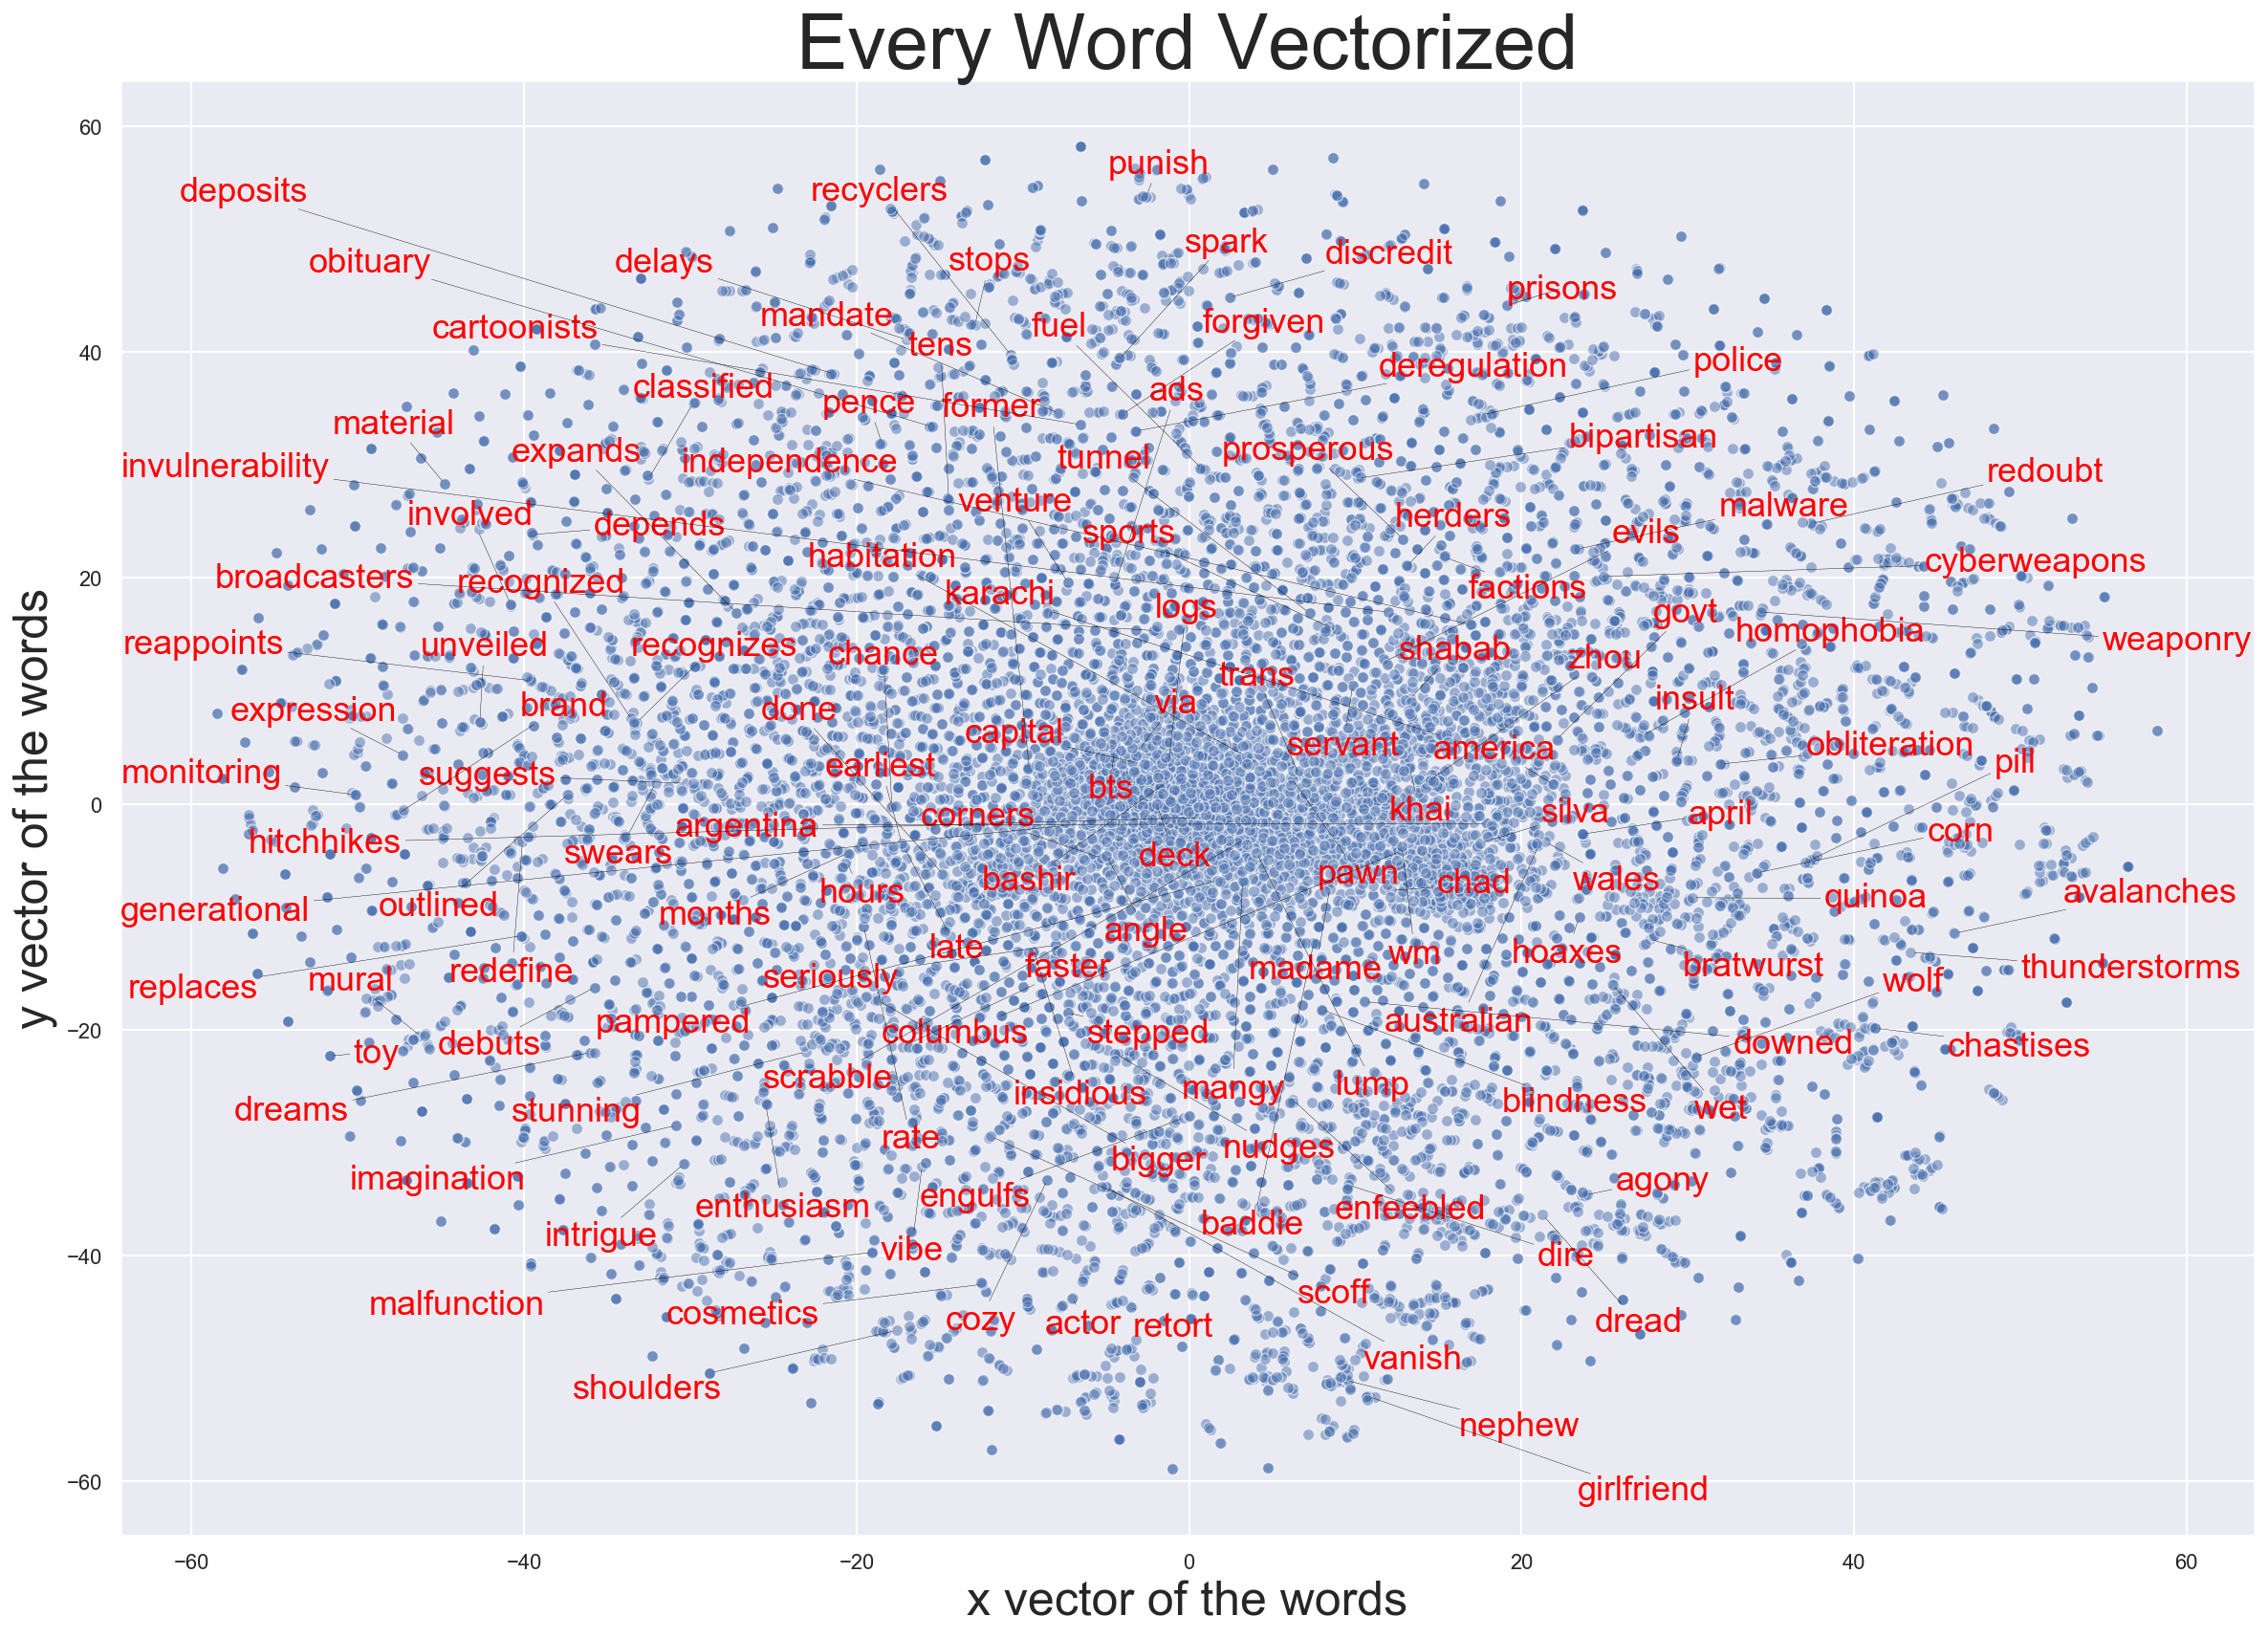

In [24]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (20, 14))
sns.scatterplot(tsne_titles[:, 0], tsne_titles[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts
texts = []
words_to_plot = list(np.arange(0, 13688, 100))
# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_titles[word, 0], tsne_titles[word, 1], title_vectors_df.index[word], fontsize = 18, color='red'))
# texts.append(plt.text(tsne_titles))
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.2))
plt.title('Every Word Vectorized', fontsize = 40)
plt.xlabel('x vector of the words', fontsize = 25)
plt.ylabel('y vector of the words', fontsize = 25)
plt.show()

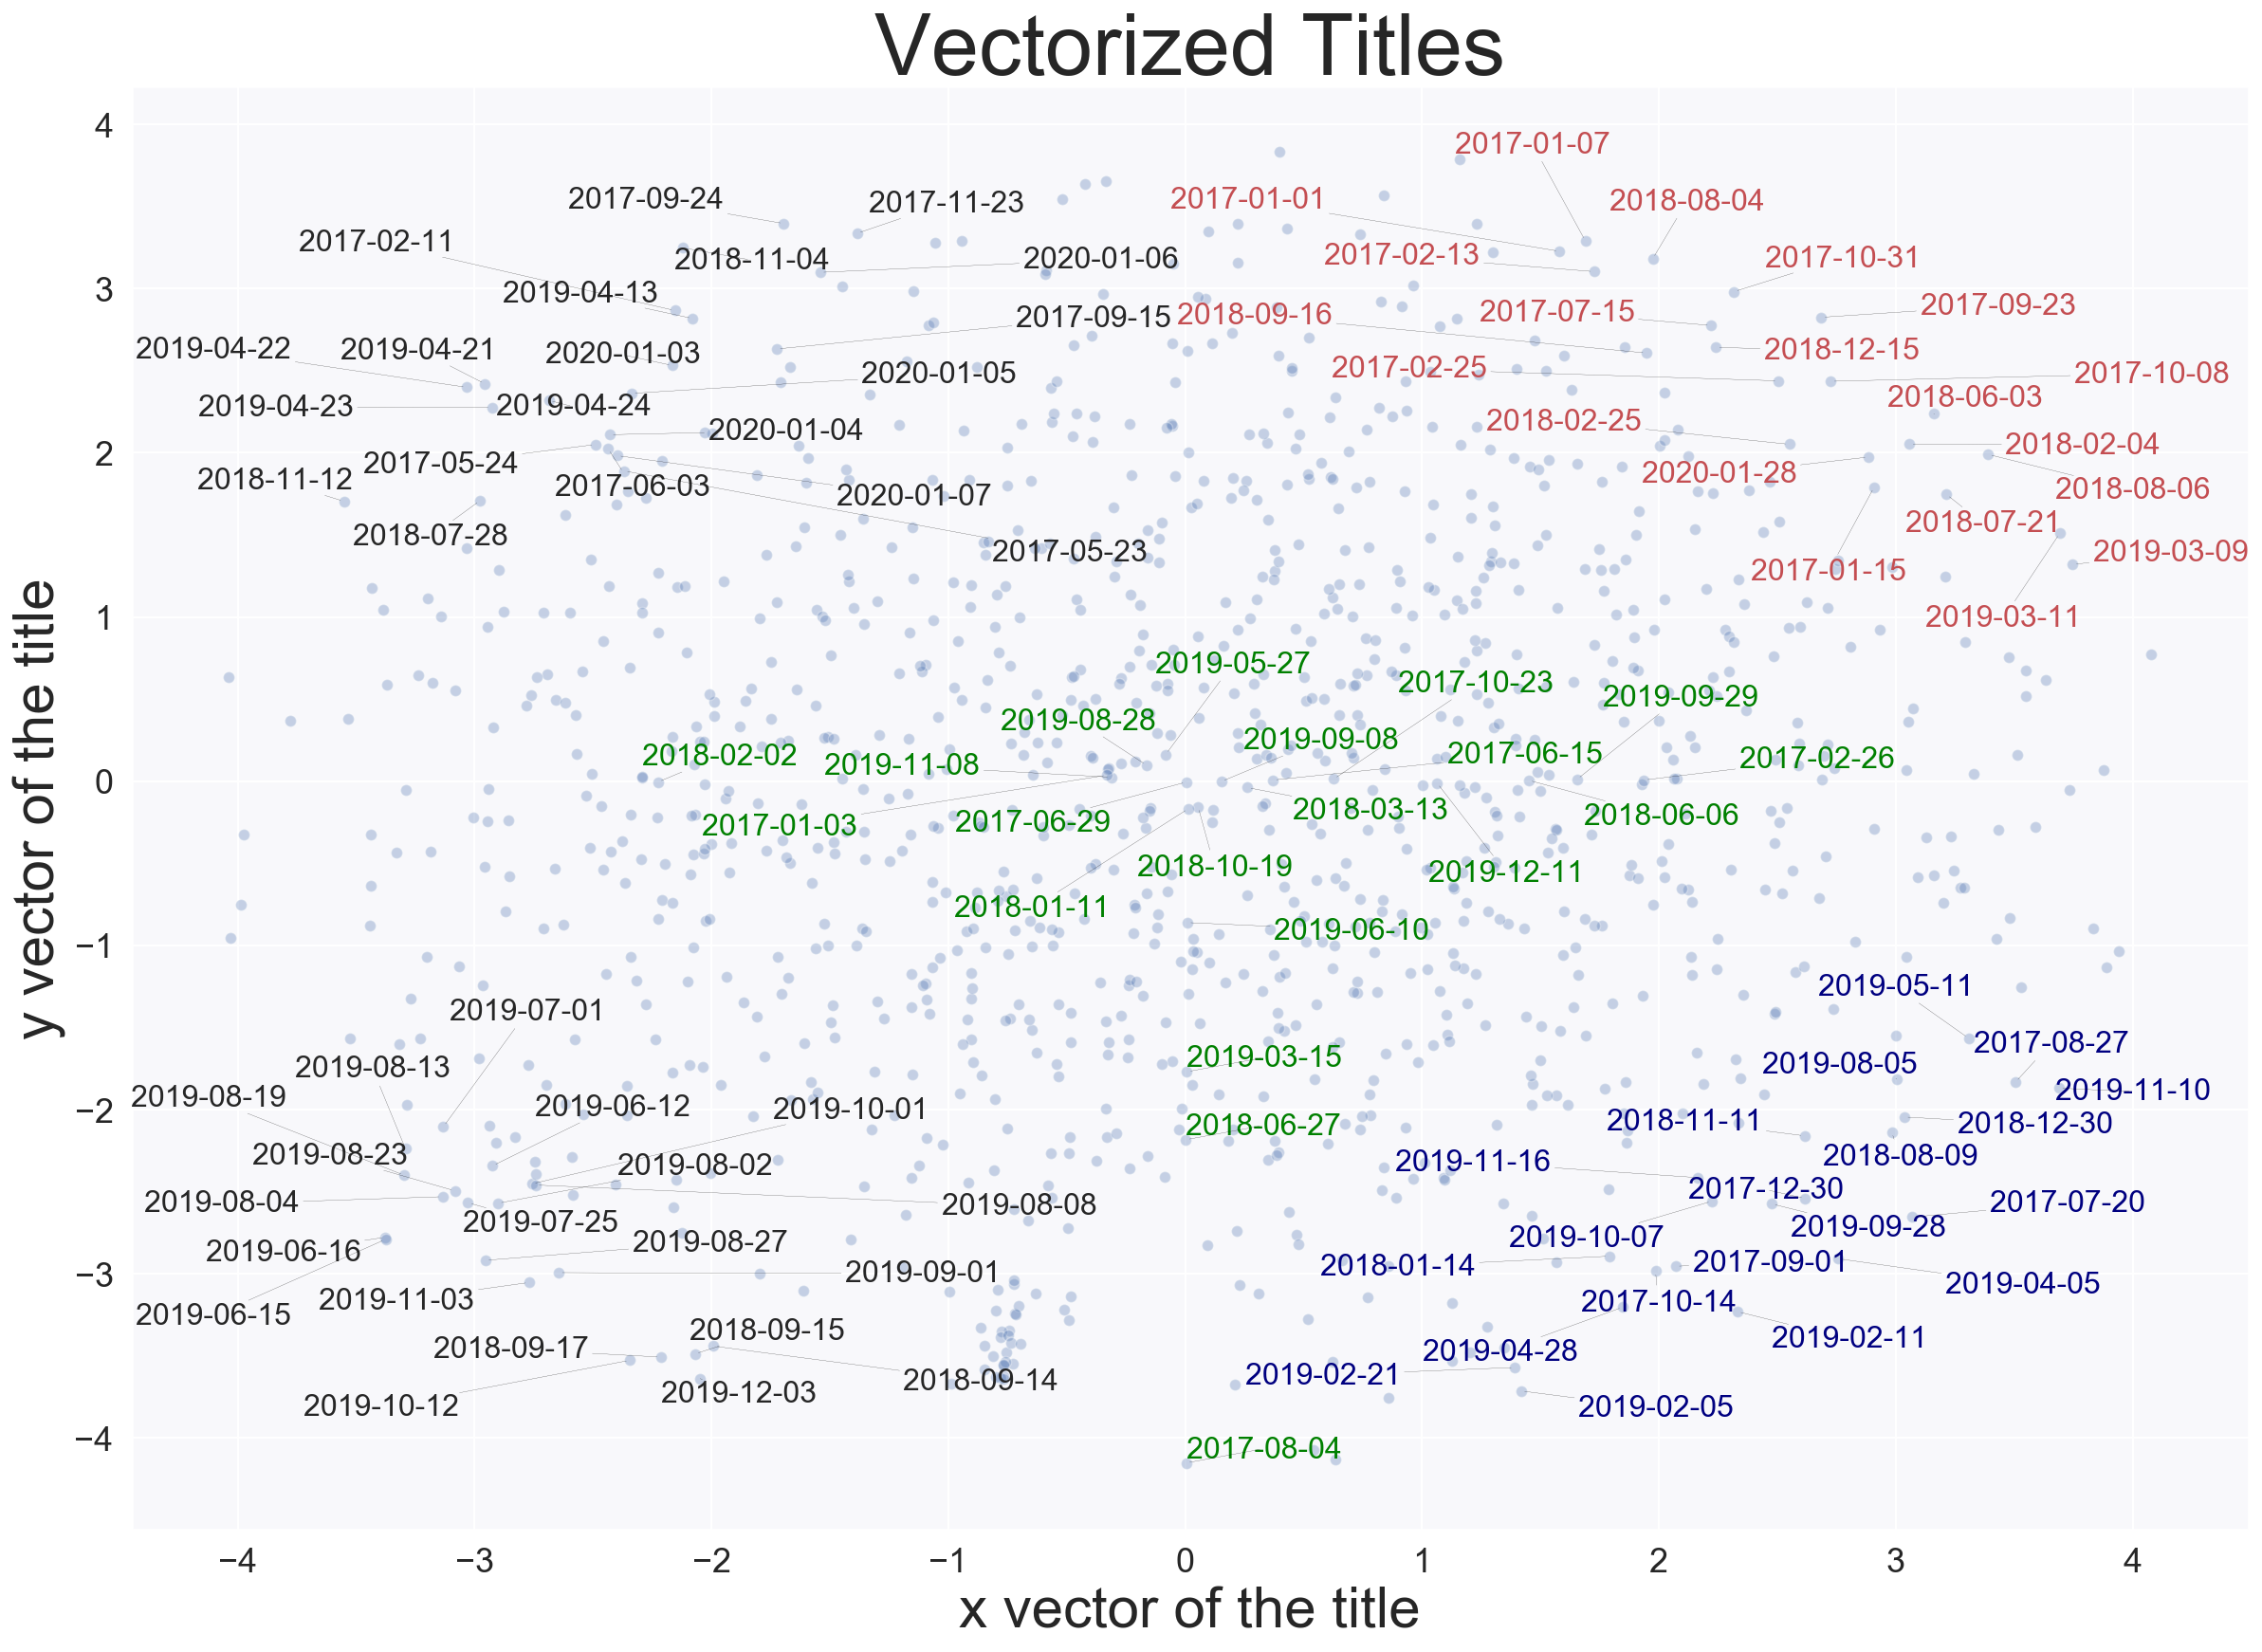

In [28]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (20, 14))
ax.patch.set_alpha(0.3)
sns.scatterplot(tsne_titles_vectorized[:, 0], tsne_titles_vectorized[:, 1], alpha = 0.3)

# Import adjustText, initialize list of texts

texts = []
words_to_plot = list(np.arange(0, 20, 1))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(zero_q_mask['x'][word], zero_q_mask['y'][word], zero_q_mask.index[word], fontsize = 16, color='green'))
    texts.append(plt.text(first_q_mask['x'][word], first_q_mask['y'][word], first_q_mask.index[word], fontsize = 16, color='r'))
    texts.append(plt.text(second_q_mask['x'][word], second_q_mask['y'][word], second_q_mask.index[word], fontsize = 16))
    texts.append(plt.text(third_q_mask['x'][word], third_q_mask['y'][word], third_q_mask.index[word], fontsize = 16, color='navy'))
    texts.append(plt.text(fourth_q_mask['x'][word], fourth_q_mask['y'][word], fourth_q_mask.index[word], fontsize = 16))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.2, force_text = 0.2, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.1))
plt.title('Vectorized Titles', fontsize = 45)
plt.xlabel('x vector of the title', fontsize = 30)
plt.ylabel('y vector of the title', fontsize = 30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

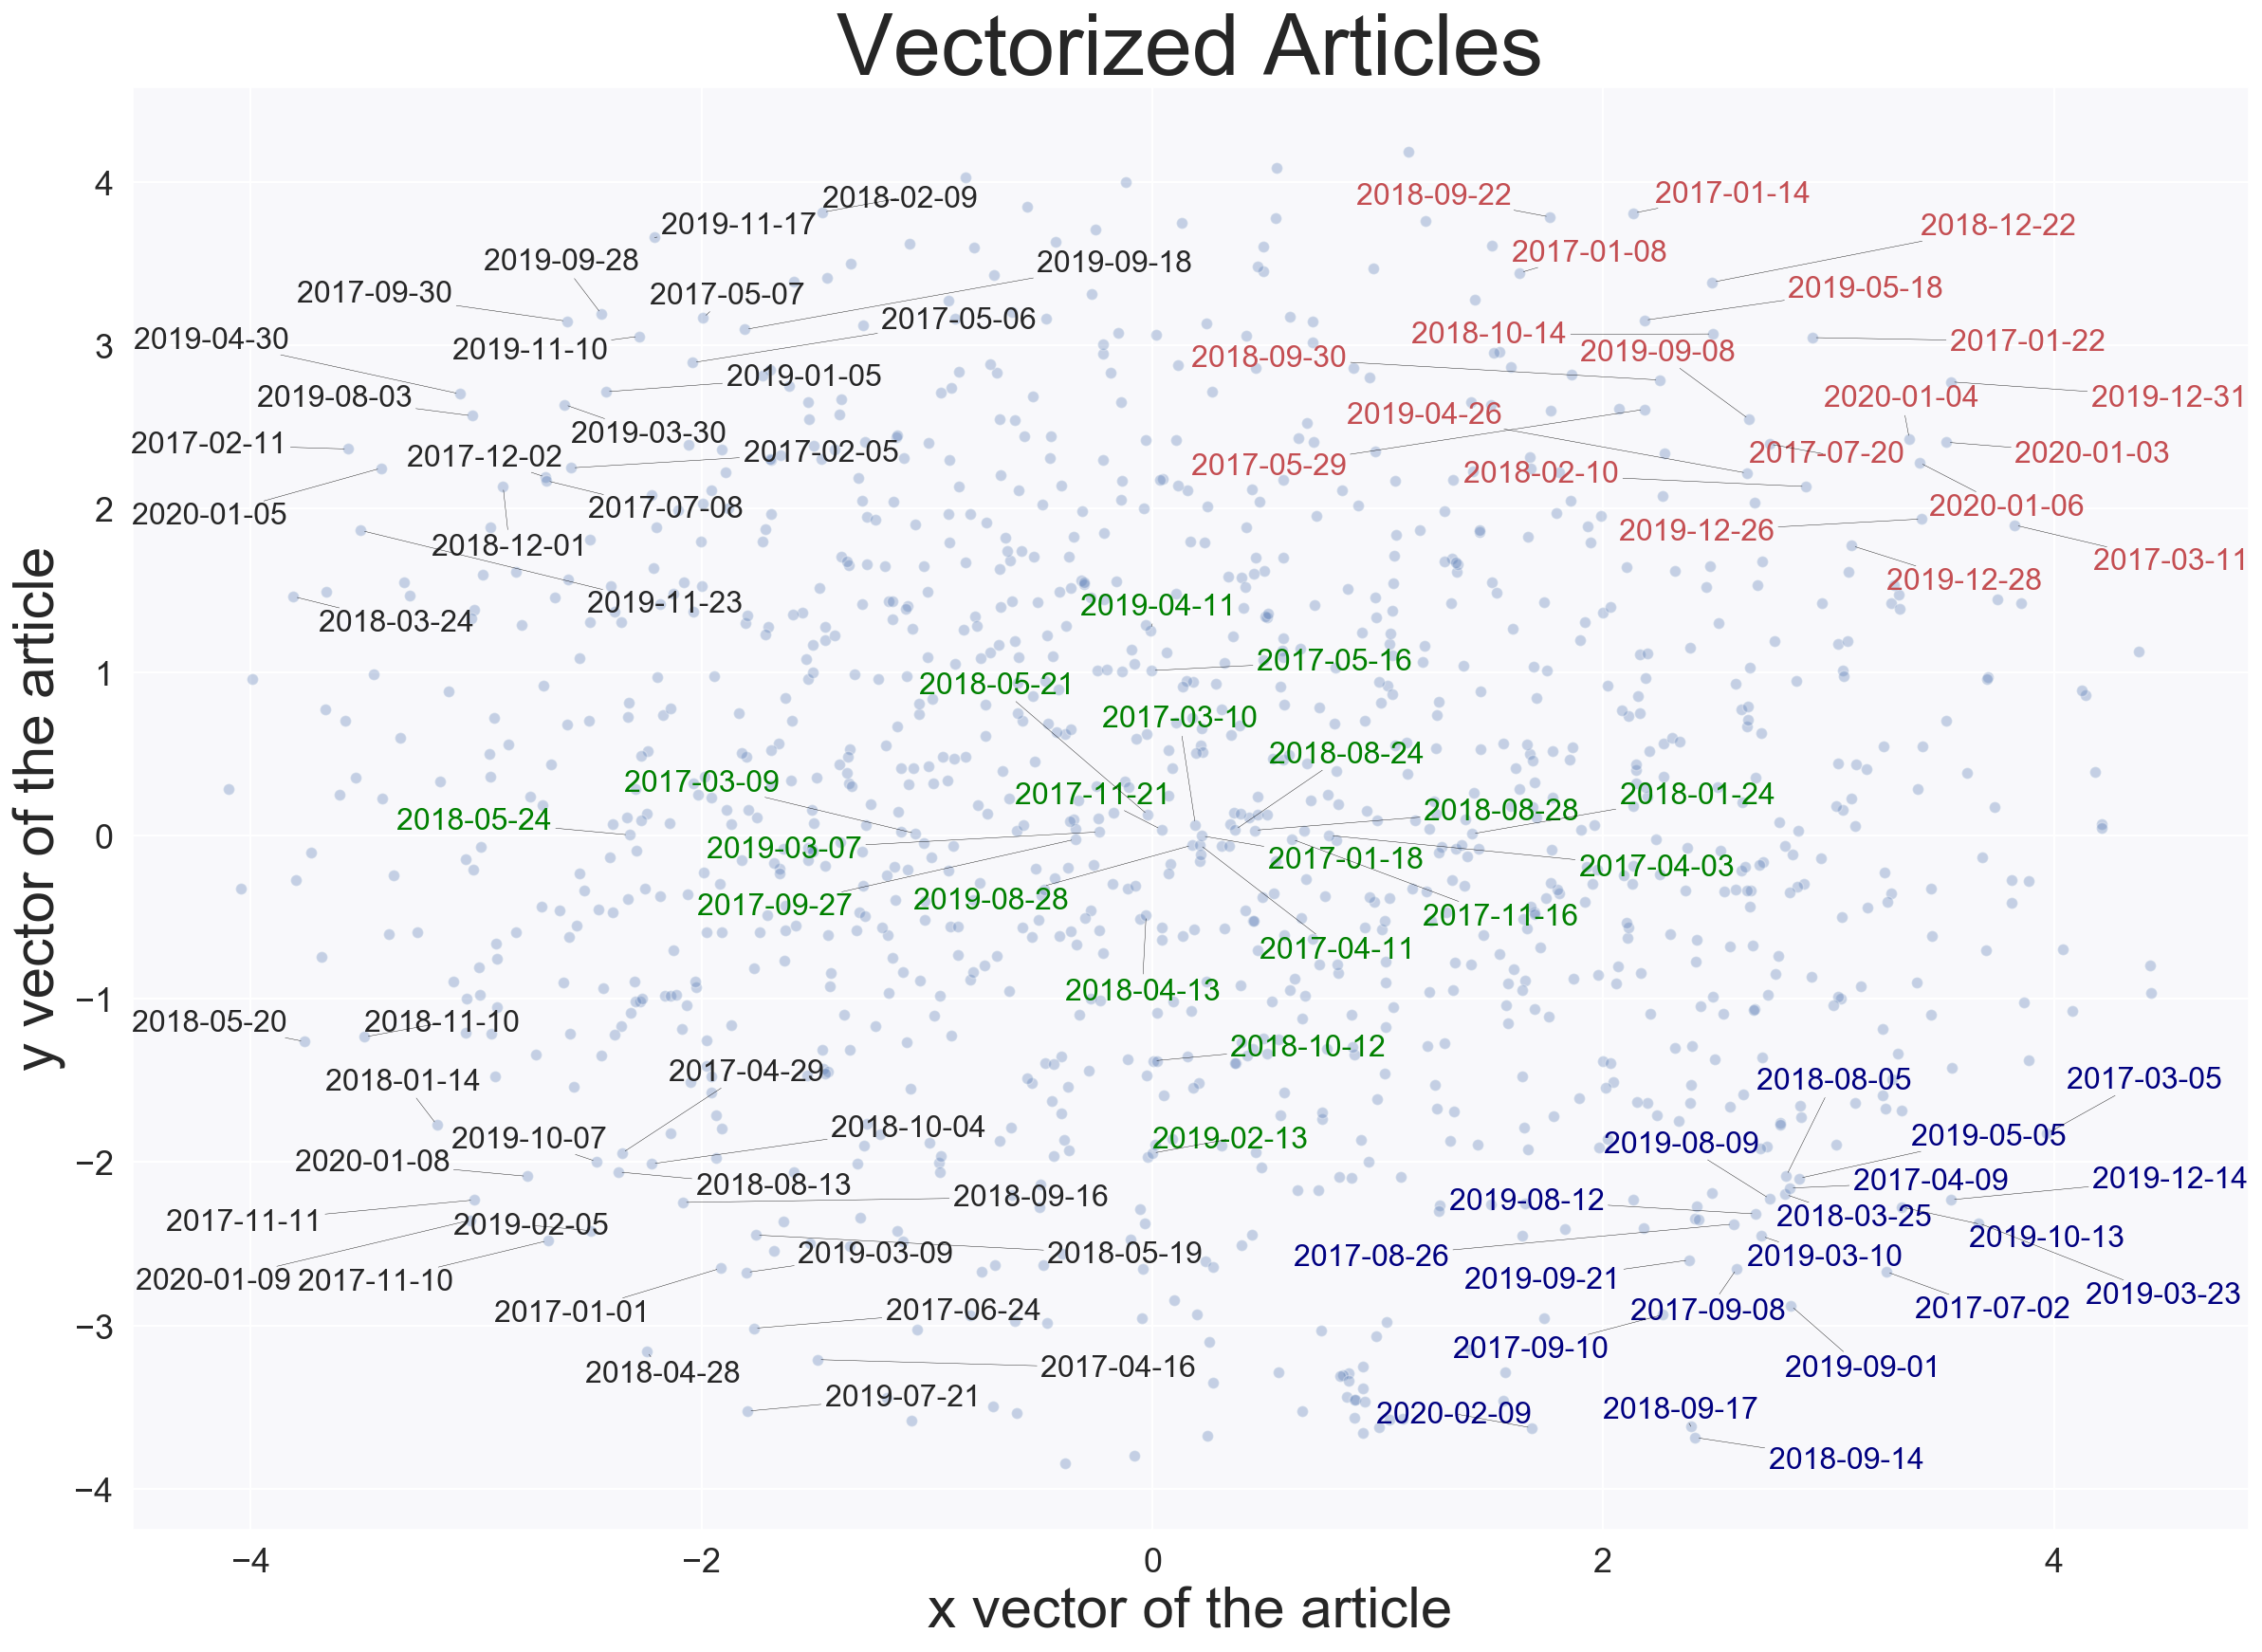

In [29]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (20, 14))
ax.patch.set_alpha(0.3)
sns.scatterplot(tsne_articles_vectorized[:, 0], tsne_articles_vectorized[:, 1], alpha = 0.3)

# Import adjustText, initialize list of texts
texts = []
words_to_plot = list(np.arange(0, 20, 1))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(zero_q_mask_a['x'][word], zero_q_mask_a['y'][word], zero_q_mask_a.index[word], fontsize = 16, color='green'))
    texts.append(plt.text(first_q_mask_a['x'][word], first_q_mask_a['y'][word], first_q_mask_a.index[word], fontsize = 16, color='r'))
    texts.append(plt.text(second_q_mask_a['x'][word], second_q_mask_a['y'][word], second_q_mask_a.index[word], fontsize = 16))
    texts.append(plt.text(third_q_mask_a['x'][word], third_q_mask_a['y'][word], third_q_mask_a.index[word], fontsize = 16, color='navy'))
    texts.append(plt.text(fourth_q_mask_a['x'][word], fourth_q_mask_a['y'][word], fourth_q_mask_a.index[word], fontsize = 16))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.2, force_text = 0.2, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.2))
plt.title('Vectorized Articles', fontsize = 45)
plt.xlabel('x vector of the article', fontsize = 30)
plt.ylabel('y vector of the article', fontsize = 30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

## Sum Vectorizing and Visualizing the Vectors

In [23]:
df_title.to_csv('../Datasets/vectorized_titles.csv')
df_article.to_csv('../Datasets/vectorized_articles.csv')
title_vectors_df.to_csv('../Datasets/vectorized_words_title.csv', index=False)
article_vectors_df.to_csv('../Datasets/vectorized_words_article.csv', index=False)